# BIAS CORRECTION qqmap

###  1990-2010 to 2030-2050

In [57]:
path_res

'/media/javi/data_win_2/IH/IberdrolaSpain/CORDEX/prcp_qqmap_2030_2050/'

In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy as sp
import scipy
from scipy import stats
import tqdm
import pickle

In [59]:
from scipy.io import netcdf
from netCDF4 import Dataset

In [60]:
def empirical_quantile_mapping_monthly(Obs, mod, raw, frec_adaptation, new_extremes):
    """Empirical-statistical downscaling and error correction of regional climate models and its impact 
    on the climate change signal. Mathias Jakob ThemeBl (2011)
    Si quisiera calibrar simplemente el periodo histórico en el input raw podría tmabién mod"""
    
    raw_calibrate=raw.copy()
    
    nn=0
    for n, month in enumerate(np.arange(1, 13)):
        ##Selecciono las fechas de mi observarvacion que sirven de referencia
        time_Obs_posi=Obs.index[Obs.index.month==month]
        ##Selecciono las fechas de mi modelo historico (Hindcast) que sirven de referencia
        time_mod_posi=mod.index[mod.index.month==month]
        ##Selecciono las fechas de mi modelo futuro (Forecast).
        time_raw_posi=raw.index[raw.index.month==month]
        
        Ycor=empirical_quantile_mapping(Obs.loc[time_Obs_posi].values, mod.loc[time_mod_posi].values, raw.loc[time_raw_posi].values,\
                                        frec_adaptation, new_extremes)
        
        
#         empirical_quantile_mapping_monthly.rc=raw_calibrate
#         empirical_quantile_mapping_monthly.trc=time_raw_posi
#         empirical_quantile_mapping_monthly.yc=Ycor
                
        raw_calibrate.loc[time_raw_posi]=Ycor.reshape(len(Ycor), 1)
    
    return raw_calibrate

In [61]:
from datetime import datetime, timedelta
from statsmodels.distributions.empirical_distribution import ECDF
def empirical_quantile_mapping(Pobs, Pmod, Praw, frec_adaptation, new_extremes):
    """
    Pcorr=ecdf-1_obs(ecdf_raw(Praw))
    Fang, G.H., Yang, J., Chen, Y.N., Zammit, C.Comparing bias correction methods in 
    downscaling meteorological variables for a hydrologic impact study in an arid area
    in China(2015) Hydrology and Earth System Sciences, 19 (6), pp. 2547-2559.
    """
    Pobs=Pobs.reshape(len(Pobs))
    Pmod=Pmod.reshape(len(Pmod))
    Praw=Praw.reshape(len(Praw))
    
    ecdf = ECDF(Pmod)#>=0
    ecdf_raw=ecdf(Praw)#>=0
    
     
    if new_extremes==True:
        ##Calibro el máximo valor de mi serie observada para generar nuevos extremos
        max_mod=np.max(Pmod); max_raw=np.max(Praw)
        min_mod=np.min(Pmod); min_raw=np.min(Praw)
        delta_max=max_raw/max_mod
        delta_min=min_raw/min_mod
        if delta_max>1:
            posi_max=np.argmax(Pobs)
            Pobs[posi_max]=delta_max*Pobs[posi_max]
    
    Pcorr=np.percentile(Pobs[Pobs>=0], 100*ecdf_raw)
    
    if frec_adaptation==True:
        ##Para ajustar los dias de lluvia genero prob aleatorias desde la minima prob de raw hasta 0
        n_min=np.sum(ecdf_raw==ecdf_raw.min())
        n_min_rand=np.random.uniform(0,ecdf_raw.min(),n_min)
        ecdf_raw[ecdf_raw==ecdf_raw.min()]=n_min_rand
        Pcorr=np.percentile(Pobs[Pobs>=0], 100*ecdf_raw)
        Pcorr[Pcorr==np.min(Pcorr)]=0##Los menores valores de Pcorr los pongo 0     
        
    return Pcorr

In [62]:
path_Spain02='/media/javi/data_win_2/IH/IberdrolaSpain/Spain02/'

# Cargo Spain02

In [63]:
root_grp = Dataset(path_Spain02 + 'Spain02_v5.0_DD_010reg_aa3d_pr.nc')
pr_Spain02 = root_grp.variables['pr'][:]
lon_Spain02 = root_grp.variables['lon'][:]
lat_Spain02 = root_grp.variables['lat'][:]
for v in root_grp.variables:
    print(v)
XX_Spain02, YY_Spain02 = np.meshgrid(lon_Spain02, lat_Spain02)

time
lat
lon
pr


In [64]:
time_Spain_02=pd.date_range('19500101', periods=len(pr_Spain02[:,0,0]))
Numero_dias=len(time_Spain_02)
print(Numero_dias)

24106


In [8]:
#me quedo con las fechas desde 1990-2010

In [9]:
posi=np.in1d(time_Spain_02.year, np.arange(1991,2011))
pr_Spain02_1990_2010=pr_Spain02[posi,:,:]
time_Spain_02_1990_2010=time_Spain_02[posi]

In [10]:
pr_Spain02_1990_2010[pr_Spain02_1990_2010<0]=np.nan

/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  if __name__ == '__main__':


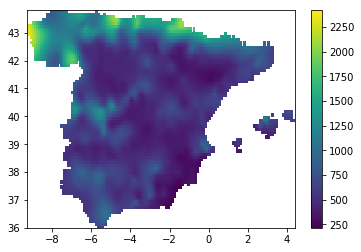

In [11]:
plt.pcolormesh(XX_Spain02, YY_Spain02, pr_Spain02_1990_2010.mean(axis=0)*365)
plt.colorbar()

# Cargo CORDEX

In [12]:
path_CORDEX='/media/javi/data_win_2/IH/IberdrolaSpain/CORDEX/prcp_ncdf/'

In [13]:
frec_adaptation=True
new_extremes=True

In [14]:
import tqdm
import time

In [15]:
path_res='/media/javi/data_win_2/IH/IberdrolaSpain/CORDEX/prcp_qqmap_2030_2050/'

In [136]:
%%capture
##Voy a calcular tendencias en CORDEX
models_time=[i for i in os.listdir(path_CORDEX) if 'time' in i]
time_CORDEX=pd.date_range(start='19500101', end='20501231')
Series_90_CORDEX_1950_2005={}
for model in models_time:
    root_grp = Dataset(path_CORDEX + model)
    #pr_CORDEX = root_grp.variables['prcp'][:]
    lon_Spain02 = root_grp.variables['lon'][:]
    lat_Spain02 = root_grp.variables['lat'][:]
    XX_CORDEX, YY_CORDEX = np.meshgrid(lon_Spain02, lat_Spain02)
    
    #plt.pcolormesh(XX_Spain02, YY_Spain02, np.nanmean(pr_CORDEX, axis=2)*365)
    #plt.colorbar()
    
    posi_1991_2010=np.in1d(time_CORDEX.year, np.arange(1991,2011))
    #pr_CORDEX_1991_2010=pr_CORDEX[:,:,posi_1991_2010]
    posi_2031_2050=np.in1d(time_CORDEX.year, np.arange(2031,2051))
    #pr_CORDEX_2031_2050=pr_CORDEX[:,:,posi_2031_2050]
    
        
    pr_CORDEX_2031_2050_qq=np.ones([np.shape(XX_Spain02)[0], np.shape(XX_Spain02)[1], np.sum(posi_2031_2050)])*np.nan
    #Empiezo con la correccion del sesgo
    n=0
    for r in tqdm.tqdm(np.arange(np.shape(XX_Spain02)[0])):
        for c in np.arange(np.shape(XX_Spain02)[1]):
            
            obs=pr_Spain02_1990_2010[:,r, c].data; obs=obs.astype(float)
            obs[obs<0]=np.nan
            if np.sum(obs>0)==0:
                pr_CORDEX_2031_2050_qq[r, c, :]=np.arange(len(pd.date_range(start='20310101', end='20501231')))*np.nan
            else:
               
                mod=root_grp.variables['prcp'][r, c, posi_1991_2010]; mod[mod<0]=np.nan; mod[mod<0.01]=0
                raw=root_grp.variables['prcp'][r, c, posi_2031_2050]; raw[raw<0]=np.nan; raw[raw<0.01]=0
                
                
                Pobs=pd.DataFrame(obs, index=pd.date_range(start='19910101', end='20101231'))
                Pmod=pd.DataFrame(mod,index=pd.date_range(start='19910101', end='20101231'))
                Praw=pd.DataFrame(raw,index=pd.date_range(start='20310101', end='20501231'))
                
                ##Pongo la media mensual donde tenga nans
                for i in Pmod.index[np.where(np.isnan(Pmod))[0]]:
                    Pmod.loc[i]=np.nanmean(Pmod.iloc[np.in1d(Pmod.index.month, i.month)])
                for i in Praw.index[np.where(np.isnan(Praw))[0]]:
                    Praw.loc[i]=np.nanmean(Praw.iloc[np.in1d(Praw.index.month, i.month)])
                
                res=empirical_quantile_mapping_monthly(Pobs, Pmod, Praw,\
                                            frec_adaptation, new_extremes)
                
                pr_CORDEX_2031_2050_qq[r, c, :]=res.values.reshape(len(res))
    
    import time
    time_created='Created ' + time.ctime(time.time())

    dataset = Dataset(path_res + model + '_qqmap.nc','w', format='NETCDF4')
    #Define a set of dimensions used for your variables:
    level = dataset.createDimension('level', 1)
    lat = dataset.createDimension('lat', len(lat_Spain02))
    lon = dataset.createDimension('lon', len(lon_Spain02))
    time = dataset.createDimension('time', np.sum(posi_2031_2050))

    times = dataset.createVariable('time', 'float64', ('time'))
    #levels = dataset.createVariable('level', np.int32, ('level',))
    latitudes = dataset.createVariable('lat', 'float64',('lat'))
    longitudes = dataset.createVariable('lon', 'float64',('lon'))
    # Create the actual 3-d variable
    #Prcp = dataset.createVariable('prcp', 'float64',('time','lat','lon'))
    Prcp = dataset.createVariable('prcp', 'float64',('lat','lon','time'))


    # Global Attributes
    dataset.description = 'bogus example script'
    dataset.history = time_created
    dataset.source = 'netCDF4 python module tutorial'

    # Variable Attributes
    latitudes.units = 'degree_north'
    longitudes.units = 'degree_east'
    #levels.units = ''
    Prcp.units = 'mm/day'
    times.units = 'days since 2031-01-01 00:00:00'
    times.calendar = 'gregorian'

    times[:] = np.arange(0,np.sum(posi_2031_2050),1)
    latitudes[:] = lat_Spain02
    longitudes[:] = lon_Spain02
    Prcp[:] = pr_CORDEX_2031_2050_qq[:,:,:]

    dataset.close()

100%|██████████| 79/79 [28:01<00:00,  9.07s/it]


In [16]:
path_pictures='/media/javi/data_win_2/IH/IberdrolaSpain/results/Analisis_CC_Historico/pictures/'

## Ploteo diferencia ppmean Spain vs modelo (1990-2010; 2030-2050)

In [17]:
files=os.listdir(path_res)

In [18]:
files=np.sort(files)

In [19]:
files

array(['CLMcom_MPI-M-MPI-ESM-LR__r1i1p1_CCLM4-8-17_v1_day.ncml_time.nc_qqmap.nc',
       'DMI_ICHEC-EC-EARTH__r3i1p1_HIRHAM5_v1_day.ncml_time.nc_qqmap.nc',
       'KNMI_ICHEC-EC-EARTH__r1i1p1_RACMO22E_v1_day.ncml_time.nc_qqmap.nc',
       'KNMI_MOHC-HadGEM2-ES__r1i1p1_RACMO22E_v2_day.ncml_time.nc_qqmap.nc',
       'MPI-CSC_MPI-M-MPI-ESM-LR__r1i1p1_REMO2009_v1_day.ncml_time.nc_qqmap.nc',
       'MPI-CSC_MPI-M-MPI-ESM-LR__r2i1p1_REMO2009_v1_day.ncml_time.nc_qqmap.nc',
       'SMHI_CNRM-CERFACS-CNRM-CM5__r1i1p1_RCA4_v1_day.ncml_time.nc_qqmap.nc',
       'SMHI_ICHEC-EC-EARTH__r12i1p1_RCA4_v1_day.ncml_time.nc_qqmap.nc',
       'SMHI_IPSL-IPSL-CM5A-MR__r1i1p1_RCA4_v1_day.ncml_time.nc_qqmap.nc',
       'SMHI_MOHC-HadGEM2-ES__r1i1p1_RCA4_v1_day.ncml_time.nc_qqmap.nc',
       'SMHI_MPI-M-MPI-ESM-LR__r1i1p1_RCA4_v1a_day.ncml_time.nc_qqmap.nc'],
      dtype='<U71')

In [20]:
files_names=np.array(['CLMcom_MPI-M-MPI-ESM-LR_r1i1p1',
       'DMI_ICHEC-EC-EARTH_r3i1p1',
       'KNMI_ICHEC-EC-EARTH_r1i1p1',
       'KNMI_HadGEM2-ES_r1i1p1',
       'MPI-M-MPI-ESM-LR_r1i1p1',
       'MPI-M-MPI-ESM-LR_r2i1p1',
       'SMHI_CNRM-CERFACS-CNRM-CM5_r1i1p1',
       'SMHI_ICHEC-EC-EARTH_r12i1p1',
       'SMHI_IPSL-IPSL-CM5A-MR_r1i1p1',
       'SMHI_MOHC-HadGEM2-ES_r1i1p1',
       'SMHI_MPI-M-MPI-ESM-LR_r1i1p1'],
      dtype='<U71')

In [35]:
diff_prcp=list()


for model in files:
    root_grp = Dataset(path_res + model)
    pr_CORDEX = root_grp.variables['prcp'][:]
    aux=pr_CORDEX; aux[aux<0]=np.nan
    aux_mean=np.nanmean(aux, axis=2)*365
    
    data=aux_mean-pr_Spain02_1990_2010.mean(axis=0)*365
    
    diff_prcp.append((np.nansum((data)))/np.sum(~np.isnan(data)))
    


/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice


In [52]:
diff_prcp

[-70.490870172249956,
 -36.130402439151659,
 -17.737084356930307,
 -19.329067931485866,
 -47.558809552231082,
 -7.4015271227656738,
 -20.645982260427996,
 1.9023882944200958,
 -103.78678395494525,
 -47.865303330298346,
 -36.875091945335591]

In [54]:
diff_prcp_dataframe=pd.DataFrame(index=files_names)
diff_prcp_dataframe['average diff mm/year ']=diff_prcp
diff_prcp_dataframe.to_csv(path_res + 'Diff_prcp.csv')

/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is depre

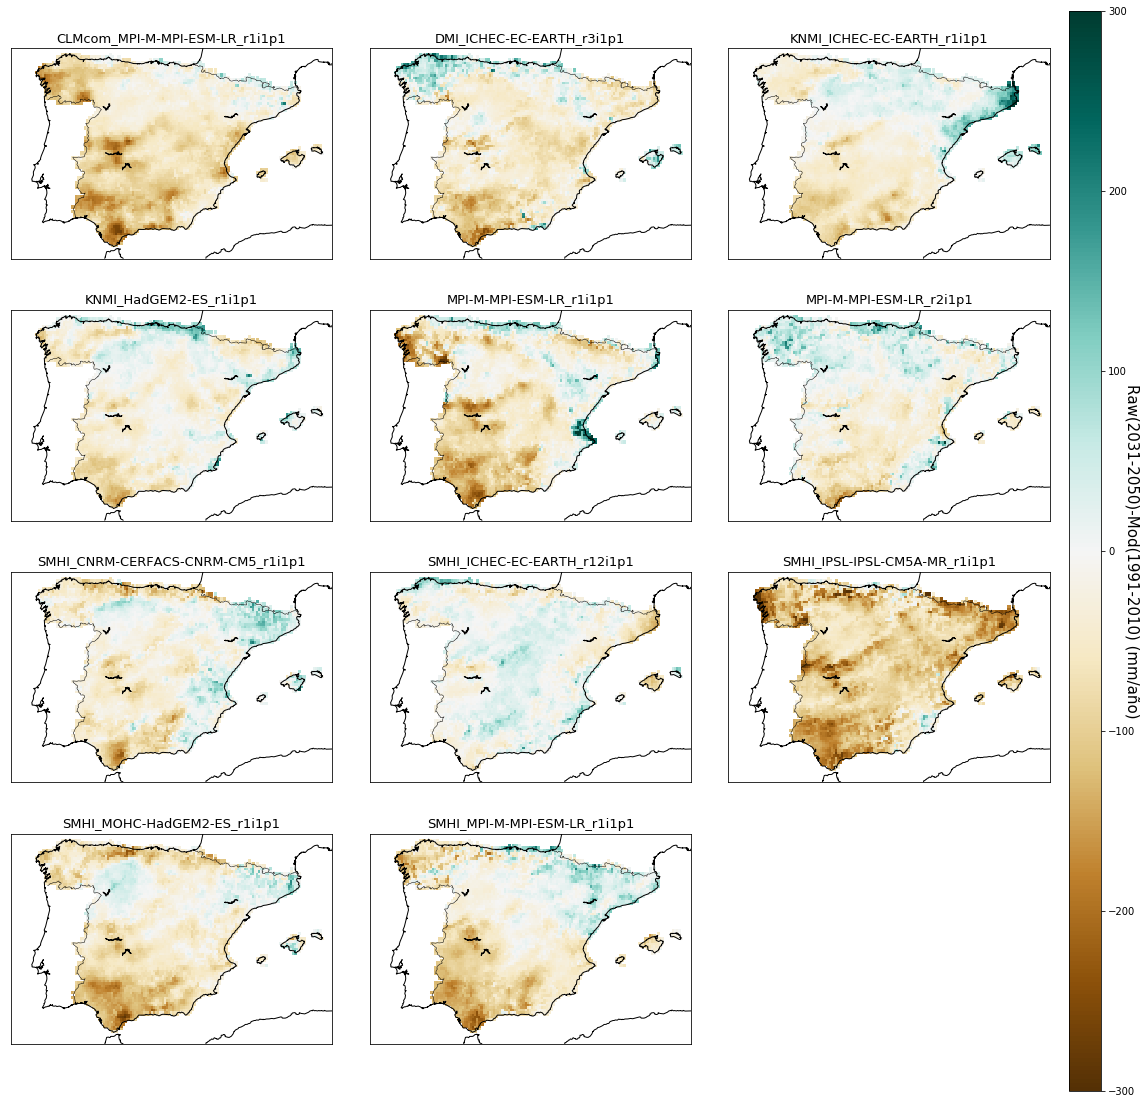

In [176]:
M=3
fig, axes = plt.subplots(nrows=4, ncols=M ,figsize=(15, 15))
mon=0
for model in files:
    root_grp = Dataset(path_res + model)
    pr_CORDEX = root_grp.variables['prcp'][:]
    aux=pr_CORDEX; aux[aux<0]=np.nan
    aux_mean=np.nanmean(aux, axis=2)*365
    
    data=aux_mean-pr_Spain02_1990_2010.mean(axis=0)*365
    data_mask=np.ma.array(data, mask = np.isnan(pr_Spain02_1990_2010[0, :, :]))

    
    col = mon % M
    row = mon // M
    
    ##Veo como queda el area de estudio
    ##Ploteo para ver que todo este bien
    #dato=np.mean(SLP, axis=0)
    m = Basemap(projection='mill',\
            llcrnrlat=35.5,urcrnrlat=44,\
            llcrnrlon=-10.5,urcrnrlon=4.8,\
            rsphere=6371200.,resolution='i',ax=axes[row, col], suppress_ticks=True)
    
    x, y = m(XX_Spain02, YY_Spain02)
    cs1=m.pcolormesh(x, y, data_mask, cmap='BrBG', vmin=-300, vmax=300)
    #cs1=m.scatter(x, y, s=40, marker="o", c=var_m.loc[6].values, cmap=cmJ, norm=LogNorm())
    m.drawcoastlines(linewidth=1.)
    m.drawcountries(linewidth=.5)

    ##En la figura vemos que n las zonas polares hace mas frio, el aire pesa más y se alcanzan los 500 hpa 
    #con una de columna de aire menos


#     axins = zoomed_inset_axes(axes[row, col], 1, loc=3)
#     axins.set_xlim(-19, -12.5)
#     axins.set_ylim(27.5, 29.5)

#     m2 = Basemap(projection='mill',\
#             llcrnrlat=27.5,urcrnrlat=29.5,\
#             llcrnrlon=-19,urcrnrlon=-12.5,\
#             rsphere=6371200.,resolution='i', suppress_ticks=True, ax=axins)

#     m2.drawcoastlines(linewidth=1.)
#     m2.drawcountries(linewidth=.5)

#     x, y = m2(Lon_90, Lat_90)
#     cs2=m2.scatter(x, y, s=40, marker="*", c='k', alpha=1)
#     cs2=m2.scatter(x, y, s=40, marker="o", c=aux.s_slope, cmap='seismic', vmin=-4, vmax=4)
#     mark_inset(axes[row, col], axins, loc1=2, loc2=4)


    
    axes[row, col].set_title(files_names[mon], fontsize=13) 
    
    mon=mon+1
    


cax = fig.add_axes([1, 0, 0.03, 1])
cbar=plt.colorbar(cs1, cax=cax, orientation='vertical')
cbar.set_label('Raw(2031-2050)-Mod(1991-2010) (mm/año)', rotation=270, fontsize=15)
    
fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=0.1, right=None, top=0.2, wspace=0.001, hspace=0.001)

fig.delaxes(axes[3,2])

    
    #cbar=plt.colorbar(cs,ax=axes[row, col])
    #cbar.set_label('Error Porcent autocorr_1 ((Observed-Simulated)/Observed)', fontsize=8)
plt.savefig(path_pictures + 'PmeanDiff_1991_2010_2031_2050.pdf', format='pdf', bbox_inches='tight')

In [157]:
models_time=[i for i in os.listdir(path_CORDEX) if 'time' in i]

In [159]:
posi_1991_2010=np.where(np.in1d(time_CORDEX.year, np.arange(1991,2011))==True)[0]
posi_2031_2050=np.where(np.in1d(time_CORDEX.year, np.arange(2031,2051))==True)[0]

In [163]:
models_time=np.sort(models_time)

/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/home/javi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/javi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axe

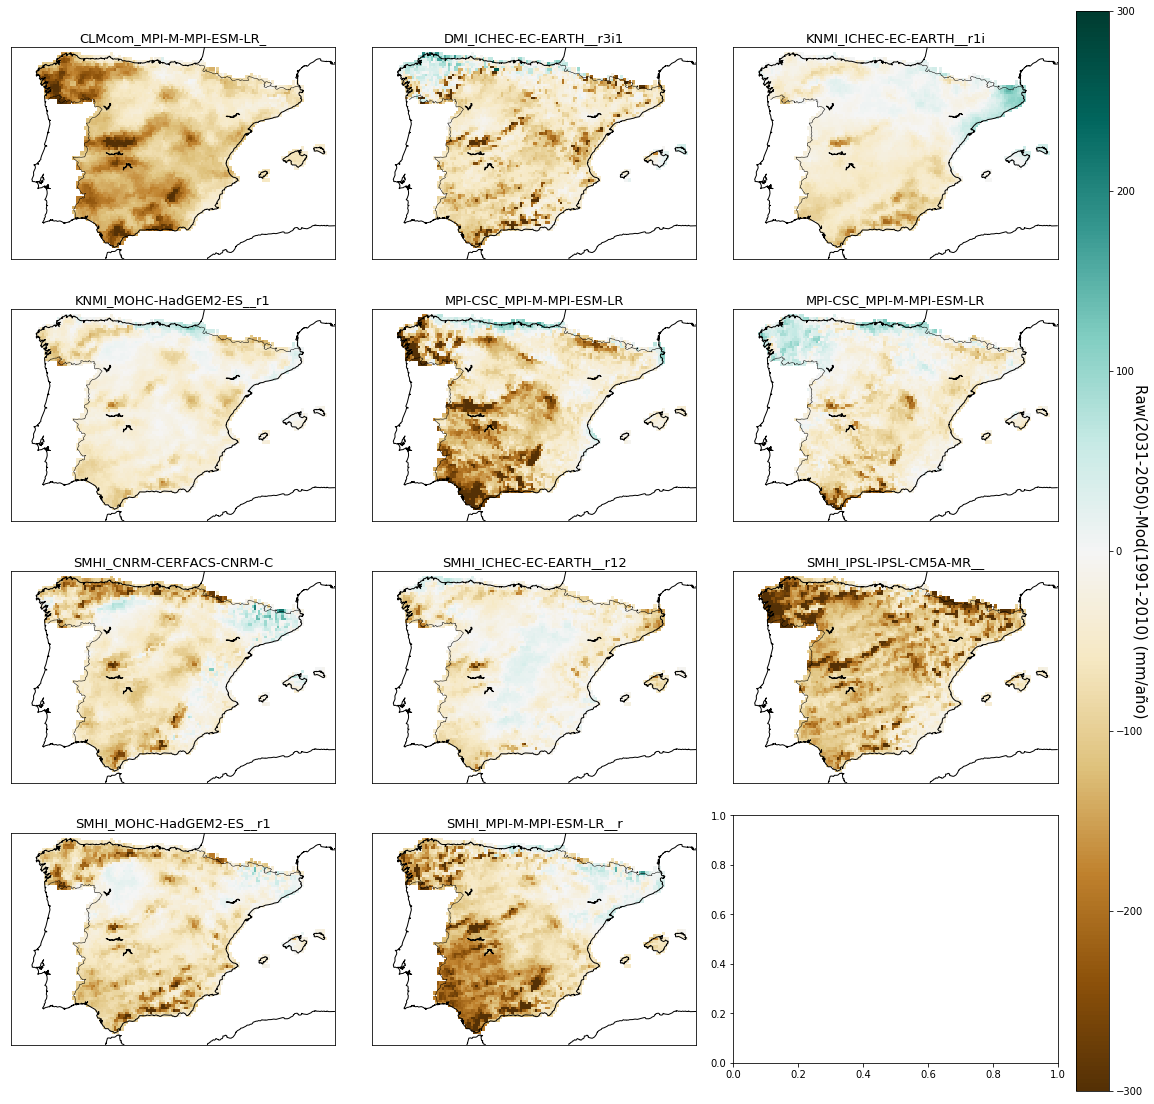

In [165]:
M=3
fig, axes = plt.subplots(nrows=4, ncols=M ,figsize=(15, 15))
mon=0
for model in models_time:
    root_grp = Dataset(path_CORDEX + model)
    pr_CORDEX_1991_2010 = root_grp.variables['prcp'][:,:,posi_1991_2010]
    aux=pr_CORDEX_1991_2010; aux[aux<0]=np.nan
    aux_mean_1991_2010=np.nanmean(aux, axis=2)*365
    
    pr_CORDEX_2031_2050 = root_grp.variables['prcp'][:,:,posi_2031_2050]
    aux=pr_CORDEX_2031_2050; aux[aux<0]=np.nan
    aux_mean_2031_2050=np.nanmean(aux, axis=2)*365
    
    data=aux_mean_2031_2050-aux_mean_1991_2010
    data_mask=np.ma.array(data, mask = np.isnan(pr_Spain02_1990_2010[0, :, :]))

    
    col = mon % M
    row = mon // M
    
    ##Veo como queda el area de estudio
    ##Ploteo para ver que todo este bien
    #dato=np.mean(SLP, axis=0)
    m = Basemap(projection='mill',\
            llcrnrlat=35.5,urcrnrlat=44,\
            llcrnrlon=-10.5,urcrnrlon=4.8,\
            rsphere=6371200.,resolution='i',ax=axes[row, col], suppress_ticks=True)
    
    x, y = m(XX_Spain02, YY_Spain02)
    cs1=m.pcolormesh(x, y, data_mask, cmap='BrBG', vmin=-300, vmax=300)
    #cs1=m.scatter(x, y, s=40, marker="o", c=var_m.loc[6].values, cmap=cmJ, norm=LogNorm())
    m.drawcoastlines(linewidth=1.)
    m.drawcountries(linewidth=.5)

    ##En la figura vemos que n las zonas polares hace mas frio, el aire pesa más y se alcanzan los 500 hpa 
    #con una de columna de aire menos


#     axins = zoomed_inset_axes(axes[row, col], 1, loc=3)
#     axins.set_xlim(-19, -12.5)
#     axins.set_ylim(27.5, 29.5)

#     m2 = Basemap(projection='mill',\
#             llcrnrlat=27.5,urcrnrlat=29.5,\
#             llcrnrlon=-19,urcrnrlon=-12.5,\
#             rsphere=6371200.,resolution='i', suppress_ticks=True, ax=axins)

#     m2.drawcoastlines(linewidth=1.)
#     m2.drawcountries(linewidth=.5)

#     x, y = m2(Lon_90, Lat_90)
#     cs2=m2.scatter(x, y, s=40, marker="*", c='k', alpha=1)
#     cs2=m2.scatter(x, y, s=40, marker="o", c=aux.s_slope, cmap='seismic', vmin=-4, vmax=4)
#     mark_inset(axes[row, col], axins, loc1=2, loc2=4)


    
    axes[row, col].set_title(model[0:24], fontsize=13) 
    
    mon=mon+1
    

cax = fig.add_axes([1, 0, 0.03, 1])
cbar=plt.colorbar(cs1, cax=cax, orientation='vertical')
cbar.set_label('Raw(2031-2050)-Mod(1991-2010) (mm/año)', rotation=270, fontsize=15)
    
fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=0.1, right=None, top=0.2, wspace=0.001, hspace=0.001)


    
    #cbar=plt.colorbar(cs,ax=axes[row, col])
    #cbar.set_label('Error Porcent autocorr_1 ((Observed-Simulated)/Observed)', fontsize=8)
#plt.savefig(path_pictures + 'S_slope_CORDEX.pdf', format='pdf', bbox_inches='tight')

## Compare Serie

In [208]:
t_2031_2050=time_CORDEX[np.where(np.in1d(time_CORDEX.year, np.arange(2031,2051))==True)[0]]

In [209]:
model='SMHI_MPI-M-MPI-ESM-LR__r1i1p1_RCA4_v1a_day.ncml_time.nc_qqmap.nc'
root_grp = Dataset(path_res + model)
pr_CORDEX = root_grp.variables['prcp'][39, 50, :]
Dataframe_serie_qq=pd.DataFrame(pr_CORDEX, index=t_2031_2050)

In [210]:
model='SMHI_MPI-M-MPI-ESM-LR__r1i1p1_RCA4_v1a_day.ncml_time.nc'
root_grp = Dataset(path_CORDEX + model)
pr_CORDEX = root_grp.variables['prcp'][39, 50, np.where(np.in1d(time_CORDEX.year, np.arange(2031,2051))==True)[0]]
Dataframe_serie=pd.DataFrame(pr_CORDEX, index=t_2031_2050)

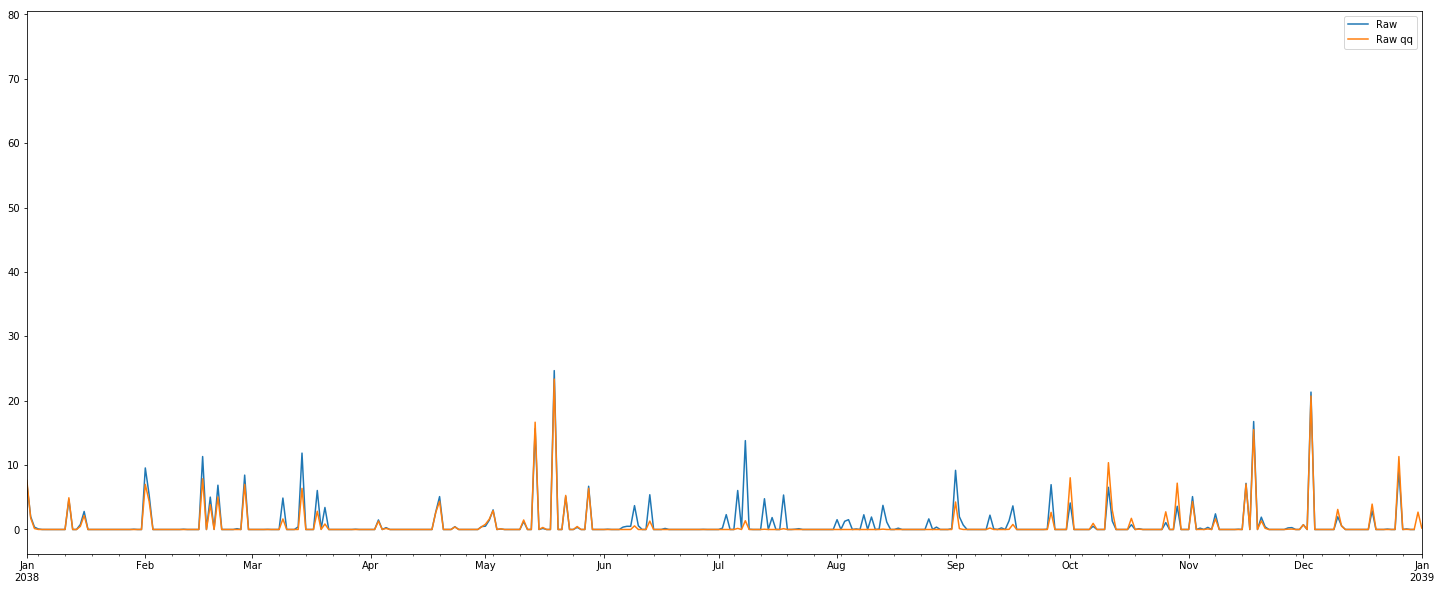

In [218]:
ax=Dataframe_serie.plot()
Dataframe_serie_qq.plot(ax=ax, figsize=(25, 10), xlim=['2038', '2039'])
plt.legend(['Raw', 'Raw qq'])

In [224]:
print(np.mean(Dataframe_serie_qq))
print(np.mean(Dataframe_serie))
print(np.mean(pr_Spain02[:, 39, 50].data))

0    0.98621
dtype: float64
0    1.390761
dtype: float64
1.19833
